In [1]:
#!git clone https://github.com/wesleymsmith/Piezo_PIP2_binding_analysis.git
#!pip install bokeh
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import scipy as sp
from scipy import stats

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
import sys
import gc
import copy
import glob

import tqdm
import itertools

# Load in Occupancy Data

In [30]:
baseDir="./"
aaOccupancyFile="All_Atom_Occupancy_2uS_Data.csv"

print 'reading all atom data'
aa_occupancy_data=pd.read_csv('/'.join([baseDir,aaOccupancyFile]))

print aa_occupancy_data.head()

cgOccupancyFileBase="Coarse_Grain_Occupancy_Data.chunk"

cgOccupancyFileList=[fileName for fileName in \
                     os.listdir(baseDir) if \
                     cgOccupancyFileBase in fileName]
#print cgOccupancyFileList
cgOccupancyChunks=[]
print 'Reading coarse grain data chunks'
cgColumns=[]
for iFile,fileName in tqdm.tqdm_notebook(enumerate(cgOccupancyFileList)):
    if 'chunk.aa' in fileName:
        cgOccupancyChunks.append(pd.read_csv('/'.join([baseDir,fileName])))
        print "cg occupancy file header:"
        cgColumns=cgOccupancyChunks[iFile].columns
        print cgColumns
    else:
        cgOccupancyChunks.append(pd.read_csv('/'.join([baseDir,fileName]),
            header=None))
for cgFrame in cgOccupancyChunks:
    cgFrame.columns=cgColumns
cg_occupancy_data=pd.concat(cgOccupancyChunks)
del(cgOccupancyChunks)
print cg_occupancy_data.head()
gc.collect()

reading all atom data
   ResID  SeqID  Frame  Time  Occupancy  Rep
0   3877   2169      0   0.0          0    0
1   3877   2169      1   1.0          0    0
2   3877   2169      2   2.0          0    0
3   3877   2169      3   3.0          0    0
4   3877   2169      4   4.0          0    0
Reading coarse grain data chunks


cg occupancy file header:
Index([u'ResID', u'SeqID', u'Frame', u'Time', u'Occupancy'], dtype='object')

   ResID  SeqID  Frame       Time  Occupancy
0    589   1497   3866  3866000.0          0
1    589   1497   3867  3867000.0          1
2    589   1497   3868  3868000.0          1
3    589   1497   3869  3869000.0          1
4    589   1497   3870  3870000.0          1


14

## Fit distributions

In [31]:
def extract_runs(x):
    return [len(list(gg)) for kk,gg in itertools.groupby(x, bool) if kk]

def extract_resDist(x):
    return(np.unique(extract_runs(x),return_counts=True))

def bin_runs(x,binWidth=1.000,frameRate=1.,center='right'):
    init_dist=extract_resDist(x)
    x_dist=(init_dist[0]*frameRate,init_dist[1])
    binMax=np.max(x_dist[0])
    nBins=np.ceil(binMax/binWidth)+1
    hbins=np.arange(nBins)*binWidth
    temp_dist=np.histogram(x_dist[0],weights=x_dist[1],bins=hbins)
    outDat=[temp_dist[1],temp_dist[0]]
    if center=='midpoint':
        outDat[0]=(temp_dist[1][1:]+temp_dist[1][:-1])/2.
    elif center=="left":
        outDat[0]=temp_dist[1][:-1]
    elif center=="right":
        outDat[0]=temp_dist[1][1:]
    return(outDat)

def expDist(x,l):
    return np.exp(-x/l)/l

def frequencyDistribution_mle_exp_params(bin_dist,bias_correction=True):
    Nv=np.sum(bin_dist[1])
    if bias_correction & (Nv>2):
        Nv=Nv-2
    return (np.sum(bin_dist[0]*bin_dist[1])/(1.*Nv))

        

def beta_dist(x,a,b):
    return (x**(a-1.)*(1.-x)**(b-1.))/\
        (sp.special.gamma(a)*sp.special.gamma(b)/sp.special.gamma(a+b))
def gamma_dist(x,t,k):
    return 1/(sp.special.gamma(k)*(t**k))*x**(k-1.)*np.exp(-x/t)

def frequencyDistribution_mle_gamma_params(bin_dist,bias_correction=True):
    xi,fi=bin_dist
    Nv=np.sum(fi)
    sum_f=np.sum(fi*xi)
    sum_lnf=np.sum(fi*np.log(xi))
    sum_flnf=np.sum(fi*xi*np.log(xi))
    k_est=(Nv*sum_f)/(Nv*sum_flnf-sum_lnf*sum_f)
    t_est=1./(Nv**2)*(Nv*sum_flnf-sum_lnf*sum_f)
    if bias_correction:
        t_est=Nv*t_est/(Nv-1)
        k_est=k_est-1./Nv*(3.*k_est-2./3.*(k_est/(1+k_est))-4./5.*(k_est/(1+k_est)**2))
    return [t_est,k_est]

def calc_GammaParams(x,fr=1.0,bw=4.8):
    return list(list(
        frequencyDistribution_mle_gamma_params(
             bin_runs(x,frameRate=fr,binWidth=bw),
             bias_correction=True))
        ) if np.sum(x)>0 else [np.nan,np.nan]

def calc_ExpParams(x,fr=1.0,bw=4.8):
    return frequencyDistribution_mle_exp_params(
                bin_runs(x,frameRate=fr,binWidth=bw)
            ) if np.sum(x)>0 else np.nan

def calc_GammaRMSE(x,fr=1.0,bw=4.8):
    if np.sum(x)>0:
        xDist=bin_runs(x,frameRate=fr,binWidth=bw)
        fitParams=calc_GammaParams(x)
        return np.sqrt(
            np.sum(
                (xDist[1]/np.sum(xDist[1])-\
                gamma_dist(xDist[0],*fitParams))**2)/\
            len(xDist[1]))
    else:
        return np.nan
        
def calc_ExpRMSE(x,fr=1.0,bw=4.8):
    if np.sum(x)>0:
        xDist=bin_runs(x,frameRate=fr,binWidth=bw)
        fitParams=[calc_ExpParams(x)]
        return np.sqrt(
            np.sum(
                (xDist[1]/np.sum(xDist[1])-\
                expDist(xDist[0],*fitParams))**2)/\
            len(xDist[1]))
    else:
        return np.nan

In [32]:
aaFrameRate=1.0 #time between frames in ns for all atom
aaBinWidth=4.0 #binning size in ns
cgFrameRate=1.0 #time between frames in ns for coarse grain
cgBinWidth=4.0

aaKwds={'fr':aaFrameRate,'bw':aaBinWidth}
cgKwds={'fr':cgFrameRate,'bw':cgBinWidth}

aaFitDat=aa_occupancy_data #[aa_occupancy_data.ResID.isin([3086,3256])]
aaFitFrame=aaFitDat.groupby(['ResID','SeqID']).agg(
    {"Occupancy": {
         "Total_Occupancy":lambda x: aaFrameRate*np.sum(x),
         "N":lambda x: len(extract_runs(x)),
         "Max_ResTime":lambda x: np.max(extract_runs(x))*aaFrameRate if np.sum(x) > 0 else 0,
         "GammaDist_Params": lambda x: calc_GammaParams(x,**aaKwds), #lambda x: list(list(frequencyDistribution_mle_gamma_params(
         #bin_runs(x,frameRate=.12,binWidth=binwidth),bias_correction=True))) if np.sum(x)>0 else [np.nan,np.nan],
        "GammaDist_RMSE":lambda x: calc_GammaRMSE(x,**aaKwds),
        "ExpDist_Mean": lambda x: calc_ExpParams(x,**aaKwds), #lambda x: frequencyDistribution_mle_exp_params(
            #bin_runs(x,frameRate=.12,binWidth=binwidth)) if np.sum(x)>0 else np.nan}
        "ExpDist_RMSE": lambda x: calc_ExpRMSE(x,**aaKwds),
    }})
aaFitFrame.columns=aaFitFrame.columns.map(lambda x: x[1])
aaFitFrame=aaFitFrame.reset_index()
aaFitFrame['GammaDist_Mean']=aaFitFrame.GammaDist_Params.map(np.product)
aaFitFrame['GammaDist_k']=aaFitFrame.GammaDist_Params.map(lambda x: x[1])
aaFitFrame=aaFitFrame.drop(columns='GammaDist_Params')
aaFitFrame['SimType']='All_Atom'
aaFitFrame=aaFitFrame[["SimType","ResID","SeqID","Total_Occupancy","N","Max_ResTime",
                       "ExpDist_Mean","ExpDist_RMSE","GammaDist_Mean","GammaDist_k","GammaDist_RMSE"]]
#aaFitFrame=aaFitFrame.dropna()
print aaFitFrame.head()

cgFitDat=cg_occupancy_data #[aa_occupancy_data.ResID.isin([3086,3256])]
cgFitFrame=cgFitDat.groupby(['ResID','SeqID']).agg(
    {"Occupancy": {
        "Total_Occupancy":np.sum,
        "N":lambda x: len(extract_runs(x)),
        "Max_ResTime":lambda x: np.max(extract_runs(x)) if np.sum(x) > 0 else 0,
        "GammaDist_Params": lambda x: calc_GammaParams(x,**cgKwds), #lambda x: list(list(frequencyDistribution_mle_gamma_params(
         #bin_runs(x,frameRate=.12,binWidth=binwidth),bias_correction=True))) if np.sum(x)>0 else [np.nan,np.nan],
        "GammaDist_RMSE": lambda x: calc_GammaRMSE(x,**cgKwds),
        "ExpDist_Mean": lambda x: calc_ExpParams(x,**cgKwds), #lambda x: frequencyDistribution_mle_exp_params(
            #bin_runs(x,frameRate=.12,binWidth=binwidth)) if np.sum(x)>0 else np.nan}
        "ExpDist_RMSE": lambda x: calc_ExpRMSE(x,**cgKwds),
    }})
cgFitFrame.columns=cgFitFrame.columns.map(lambda x: x[1])
cgFitFrame=cgFitFrame.reset_index()
cgFitFrame['GammaDist_Mean']=cgFitFrame.GammaDist_Params.map(np.product)
cgFitFrame['GammaDist_k']=cgFitFrame.GammaDist_Params.map(lambda x: x[1])
cgFitFrame=cgFitFrame.drop(columns='GammaDist_Params')
cgFitFrame['SimType']='Coarse_Grain'
cgFitFrame=cgFitFrame[["SimType","ResID","SeqID","Total_Occupancy","N","Max_ResTime",
                       "ExpDist_Mean","ExpDist_RMSE","GammaDist_Mean","GammaDist_k","GammaDist_RMSE"]]
#cgFitFrame=cgFitFrame.dropna()
print cgFitFrame.head()

/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide
/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars
/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply


    SimType  ResID  SeqID  Total_Occupancy   N  Max_ResTime  ExpDist_Mean  \
0  All_Atom      1    782              171  27           32      9.280000   
1  All_Atom     15    796              268  38           44     10.111111   
2  All_Atom     21    802              810  45          159     21.488372   
3  All_Atom     22    803              903  14          539     78.333333   
4  All_Atom     30    811               87  15           50      9.538462   

   ExpDist_RMSE  GammaDist_Mean  GammaDist_k  GammaDist_RMSE  
0      0.032096        8.047528     1.564721        0.040372  
1      0.026742        9.169857     1.292284        0.031632  
2      0.010855       19.911491     0.666266        0.010335  
3      0.003341       61.328587     0.348635        0.003401  
4      0.024822        7.386159     0.892159        0.026995  


/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in power


        SimType  ResID  SeqID  Total_Occupancy    N  Max_ResTime  \
0  Coarse_Grain      1    782             5212  256          141   
1  Coarse_Grain     15    796             2012  309          423   
2  Coarse_Grain     21    802                0    0            0   
3  Coarse_Grain     22    803                0    0            0   
4  Coarse_Grain     30    811                0    0            0   

   ExpDist_Mean  ExpDist_RMSE  GammaDist_Mean  GammaDist_k  GammaDist_RMSE  
0     23.039370      0.011198       22.724661     1.094233        0.011517  
1      9.094463      0.008829        8.998251     0.599033        0.007495  
2           NaN           NaN             NaN          NaN             NaN  
3           NaN           NaN             NaN          NaN             NaN  
4           NaN           NaN             NaN          NaN             NaN  


In [33]:
jointFitFrame=pd.concat([aaFitFrame,cgFitFrame])
jointFitFrame.to_csv(baseDir+"joint_distribution_fit_frame.csv",index=False)
jointFitFrame.head()

,SimType,ResID,SeqID,Total_Occupancy,N,Max_ResTime,ExpDist_Mean,ExpDist_RMSE,GammaDist_Mean,GammaDist_k,GammaDist_RMSE
0,All_Atom,1,782,171,27,32,9.280000,0.032096,8.047528,1.564721,0.040372
1,All_Atom,15,796,268,38,44,10.111111,0.026742,9.169857,1.292284,0.031632
2,All_Atom,21,802,810,45,159,21.488372,0.010855,19.911491,0.666266,0.010335
3,All_Atom,22,803,903,14,539,78.333333,0.003341,61.328587,0.348635,0.003401
4,All_Atom,30,811,87,15,50,9.538462,0.024822,7.386159,0.892159,0.026995


In [38]:
jointFitMelt=jointFitFrame.melt(id_vars=["SimType","ResID","SeqID"],var_name="Fit_Param")
print jointFitMelt.head()

jointFitWide=jointFitMelt
jointFitWide["Measurement"]=jointFitWide.SimType+"."+jointFitWide.Fit_Param
jointFitWide=jointFitWide.drop(columns=["SimType","Fit_Param"])
jointFitWide=jointFitWide.reset_index()
jointFitWide=pd.pivot_table(index=["ResID","SeqID"],columns="Measurement",values="value",data=jointFitWide)
#jointFitWide.columns=jointFitWide.columns.map(lambda x: x[1])
jointFitWide=jointFitWide.reset_index()
print jointFitWide.columns
jointFitWide.to_csv(baseDir+"joint_Fit_Data_wide.csv",index=False)
jointFitWide.head()

    SimType  ResID  SeqID        Fit_Param  value
0  All_Atom      1    782  Total_Occupancy  171.0
1  All_Atom     15    796  Total_Occupancy  268.0
2  All_Atom     21    802  Total_Occupancy  810.0
3  All_Atom     22    803  Total_Occupancy  903.0
4  All_Atom     30    811  Total_Occupancy   87.0
Index([u'ResID', u'SeqID', u'All_Atom.ExpDist_Mean', u'All_Atom.ExpDist_RMSE',
       u'All_Atom.GammaDist_Mean', u'All_Atom.GammaDist_RMSE',
       u'All_Atom.GammaDist_k', u'All_Atom.Max_ResTime', u'All_Atom.N',
       u'All_Atom.Total_Occupancy', u'Coarse_Grain.ExpDist_Mean',
       u'Coarse_Grain.ExpDist_RMSE', u'Coarse_Grain.GammaDist_Mean',
       u'Coarse_Grain.GammaDist_RMSE', u'Coarse_Grain.GammaDist_k',
       u'Coarse_Grain.Max_ResTime', u'Coarse_Grain.N',
       u'Coarse_Grain.Total_Occupancy'],
      dtype='object', name=u'Measurement')


Measurement,ResID,SeqID,All_Atom.ExpDist_Mean,All_Atom.ExpDist_RMSE,All_Atom.GammaDist_Mean,All_Atom.GammaDist_RMSE,All_Atom.GammaDist_k,All_Atom.Max_ResTime,All_Atom.N,All_Atom.Total_Occupancy,Coarse_Grain.ExpDist_Mean,Coarse_Grain.ExpDist_RMSE,Coarse_Grain.GammaDist_Mean,Coarse_Grain.GammaDist_RMSE,Coarse_Grain.GammaDist_k,Coarse_Grain.Max_ResTime,Coarse_Grain.N,Coarse_Grain.Total_Occupancy
0,1,782,9.280000,0.032096,8.047528,0.040372,1.564721,32.0,27.0,171.0,23.039370,0.011198,22.724661,0.011517,1.094233,141.0,256.0,5212.0
1,15,796,10.111111,0.026742,9.169857,0.031632,1.292284,44.0,38.0,268.0,9.094463,0.008829,8.998251,0.007495,0.599033,423.0,309.0,2012.0
2,21,802,21.488372,0.010855,19.911491,0.010335,0.666266,159.0,45.0,810.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,22,803,78.333333,0.003341,61.328587,0.003401,0.348635,539.0,14.0,903.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,30,811,9.538462,0.024822,7.386159,0.026995,0.892159,50.0,15.0,87.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [39]:
jointFitWide=pd.read_csv(baseDir+"joint_Fit_Data_Wide.csv")
jointFitWide.head()

,ResID,SeqID,All_Atom.ExpDist_Mean,All_Atom.ExpDist_RMSE,All_Atom.GammaDist_Mean,All_Atom.GammaDist_RMSE,All_Atom.GammaDist_k,All_Atom.Max_ResTime,All_Atom.N,All_Atom.Total_Occupancy,Coarse_Grain.ExpDist_Mean,Coarse_Grain.ExpDist_RMSE,Coarse_Grain.GammaDist_Mean,Coarse_Grain.GammaDist_RMSE,Coarse_Grain.GammaDist_k,Coarse_Grain.Max_ResTime,Coarse_Grain.N,Coarse_Grain.Total_Occupancy
0,1,782,9.280000,0.032096,8.047528,0.040372,1.564721,32.0,27.0,171.0,23.039370,0.011198,22.724661,0.011517,1.094233,141.0,256.0,5212.0
1,15,796,10.111111,0.026742,9.169857,0.031632,1.292284,44.0,38.0,268.0,9.094463,0.008829,8.998251,0.007495,0.599033,423.0,309.0,2012.0
2,21,802,21.488372,0.010855,19.911491,0.010335,0.666266,159.0,45.0,810.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,22,803,78.333333,0.003341,61.328587,0.003401,0.348635,539.0,14.0,903.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,30,811,9.538462,0.024822,7.386159,0.026995,0.892159,50.0,15.0,87.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


# Load SASA Data and compute trajectory means

In [40]:
baseDir="./"
#baseDir="Piezo_PIP2_binding_analysis/"

sasa_data=pd.read_csv(baseDir+"basicResidueSASA.csv")
sasa_data.head()

,System,Frame,ARG_1,ARG_15,ARG_21,ARG_22,HSD_27,LYS_30,LYS_42,ARG_63,...,HSD_4198,ARG_4210,LYS_4213,ARG_4222,ARG_4225,LYS_4236,ARG_4242,LYS_4249,ARG_4252,ARG_4254
0,Piezo_PIP2,0,287.440560,274.898960,324.281827,540.105388,382.686118,172.673159,102.452724,221.306778,...,494.523318,278.618895,116.343258,629.556884,299.282841,140.083915,646.955674,103.634013,282.838529,205.066848
1,Piezo_PIP2,1,334.816766,183.629963,283.576915,578.829623,384.278017,103.769143,109.288093,243.110699,...,355.490064,257.677793,98.921705,453.885378,416.310184,131.922552,462.089912,95.179939,242.496894,223.123915
2,Piezo_PIP2,2,275.073755,202.255450,342.219028,560.460974,336.459908,111.187833,102.056689,240.717753,...,403.091530,300.392173,85.993276,465.202440,257.272547,72.081927,535.732493,82.812868,218.384865,218.979063
3,Piezo_PIP2,3,290.577028,193.342330,351.953645,680.849566,356.348260,126.432774,103.091409,239.646221,...,418.481454,332.128525,96.114586,567.150851,259.985159,88.943817,501.348161,95.815112,247.253744,220.677821
4,Piezo_PIP2,4,233.699040,203.015984,240.717316,603.387966,328.979551,127.112652,111.054757,232.711257,...,410.296426,309.629827,104.504957,468.422037,291.298963,93.244969,460.571667,93.286728,271.298287,222.949990


In [41]:
sasa_data_long=sasa_data.melt(id_vars=['System','Frame'],var_name='Residue',value_name='SASA')
sasa_data_long['ResID']=sasa_data_long.Residue.map(lambda x: x.split('_')[-1])
sasa_data_long['ResName']=sasa_data_long.Residue.map(lambda x: x.split('_')[0])
sasa_data_long['SimType']='All_Atom'
sasa_data_long=sasa_data_long[['System','SimType','ResID','ResName','Frame','SASA']]
sasa_data_long.head()

,System,SimType,ResID,ResName,Frame,SASA
0,Piezo_PIP2,All_Atom,1,ARG,0,287.440560
1,Piezo_PIP2,All_Atom,1,ARG,1,334.816766
2,Piezo_PIP2,All_Atom,1,ARG,2,275.073755
3,Piezo_PIP2,All_Atom,1,ARG,3,290.577028
4,Piezo_PIP2,All_Atom,1,ARG,4,233.699040


In [42]:
sasa_summary=sasa_data_long.groupby(['System','SimType','ResID','ResName']).agg({'SASA':np.mean})
sasa_summary=sasa_summary.reset_index()
sasa_summary.ResID=pd.Series(sasa_summary.ResID,dtype=int)
sasa_summary.head()

,System,SimType,ResID,ResName,SASA
0,Piezo_PIP2,All_Atom,1,ARG,227.088237
1,Piezo_PIP2,All_Atom,1007,ARG,375.628680
2,Piezo_PIP2,All_Atom,1038,LYS,112.130846
3,Piezo_PIP2,All_Atom,1041,ARG,286.585983
4,Piezo_PIP2,All_Atom,1045,LYS,110.187461


In [43]:
sasa_corr=jointFitWide.set_index("ResID").join(
        other=sasa_summary.drop(columns=["System","SimType"]).set_index("ResID")
    ).reset_index()
sasa_corr.to_csv(baseDir+"SASA_correlation_dataFrame.csv",index=False)
sasa_corr.head()

,ResID,SeqID,All_Atom.ExpDist_Mean,All_Atom.ExpDist_RMSE,All_Atom.GammaDist_Mean,All_Atom.GammaDist_RMSE,All_Atom.GammaDist_k,All_Atom.Max_ResTime,All_Atom.N,All_Atom.Total_Occupancy,Coarse_Grain.ExpDist_Mean,Coarse_Grain.ExpDist_RMSE,Coarse_Grain.GammaDist_Mean,Coarse_Grain.GammaDist_RMSE,Coarse_Grain.GammaDist_k,Coarse_Grain.Max_ResTime,Coarse_Grain.N,Coarse_Grain.Total_Occupancy,ResName,SASA
0,1,782,9.280000,0.032096,8.047528,0.040372,1.564721,32.0,27.0,171.0,23.039370,0.011198,22.724661,0.011517,1.094233,141.0,256.0,5212.0,ARG,227.088237
1,15,796,10.111111,0.026742,9.169857,0.031632,1.292284,44.0,38.0,268.0,9.094463,0.008829,8.998251,0.007495,0.599033,423.0,309.0,2012.0,ARG,269.308386
2,21,802,21.488372,0.010855,19.911491,0.010335,0.666266,159.0,45.0,810.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,ARG,278.032111
3,22,803,78.333333,0.003341,61.328587,0.003401,0.348635,539.0,14.0,903.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,ARG,684.723468
4,30,811,9.538462,0.024822,7.386159,0.026995,0.892159,50.0,15.0,87.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,LYS,130.928857


/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


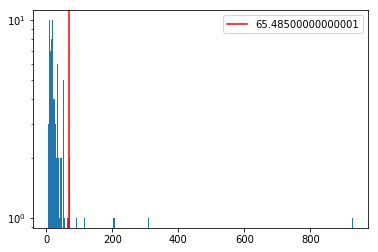

In [60]:
plt.hist(sasa_corr.dropna()[sasa_corr['All_Atom.N']>3]['All_Atom.ExpDist_Mean'],bins=300)
plt.axvline(np.quantile(sasa_corr.dropna()['All_Atom.ExpDist_Mean'],q=.9),c='r',
            label=np.quantile(sasa_corr.dropna()[sasa_corr['All_Atom.N']>3]['All_Atom.ExpDist_Mean'],q=.9))
plt.legend()
plt.yscale('log')
plt.show()